# Ch2 | Embedding：语言模型的灵魂

---

**目标：** 理解词向量是如何工作的

**核心问题：** 机器如何"理解"文字？

---

## 本章内容

1. **Lookup Table**：揭秘 `nn.Embedding` 的本质
2. **训练演示**：用 Bigram 模型训练词向量
3. **可视化**：看词向量在空间中的分布

---

## 🎓 前置知识：为什么机器需要"理解"文字？

### 机器的困境

计算机只能处理**数字**，不能直接处理文字：

```python
# 这样不行！
model("你好")  # ❌ 机器不懂

# 需要转换成数字
model([1, 2, 3])  # ✓ 机器能处理
```

### 最简单的方法：One-Hot 编码

给每个词一个独特的"编号向量"：

```
词表: [猫, 狗, 鸟]
猫 → [1, 0, 0]
狗 → [0, 1, 0]  
鸟 → [0, 0, 1]
```

**问题**：
- 维度太高（词表10万 → 10万维向量）
- 无法表达语义关系（"猫"和"狗"的距离 = "猫"和"汽车"的距离）

### 解决方案：Embedding（词嵌入）

把每个词映射到一个**低维、稠密**的向量：

```
猫 → [0.2, 0.8, -0.3, 0.5]  (4维)
狗 → [0.3, 0.7, -0.2, 0.4]  (相似！)
汽车 → [-0.8, 0.1, 0.9, -0.2]  (不相似)
```

**核心思想**：语义相近的词，向量也相近！

### 本章目标

- 理解 `nn.Embedding` 的本质（就是查表！）
- 亲手训练词向量
- 可视化词向量空间

## 0. 环境准备

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import os
from matplotlib import font_manager as fm
import matplotlib as mpl
font_path = "../assets/fonts/NotoSansCJKsc-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

torch.manual_seed(42)
np.random.seed(42) 

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu128


---

## 1. Embedding 的本质：一个查表矩阵

忘掉复杂的数学定义！`nn.Embedding` 就是：

```
一个形状为 [词表大小, 向量维度] 的矩阵
```

当你输入一个词的索引，它就返回对应的那一行向量。就这么简单！

In [7]:
# 创建一个简单的 Embedding 层
vocab_size = 10  # 词表大小
embed_dim = 4    # 每个词用4维向量表示

embedding = nn.Embedding(vocab_size, embed_dim)

print("Embedding 矩阵形状:", embedding.weight.shape)
print("\nEmbedding 矩阵内容（随机初始化）:")
print(embedding.weight.data)

Embedding 矩阵形状: torch.Size([10, 4])

Embedding 矩阵内容（随机初始化）:
tensor([[ 0.8637, -0.5890, -1.0340, -0.2179],
        [ 0.7987,  0.9105, -0.0880,  0.3370],
        [-0.4808,  0.3163,  0.3866,  0.7337],
        [ 0.2510,  0.0770, -0.2063,  2.1698],
        [ 0.5230,  0.9717, -0.2779, -0.6116],
        [-0.5572, -0.9683,  0.8713, -0.0956],
        [ 0.4334, -0.7172,  1.0554, -1.4534],
        [ 0.4652,  0.3714, -0.0047,  0.0795],
        [ 0.3782,  0.7051, -1.7237, -0.8435],
        [ 0.4351,  0.2659, -0.5871,  0.0827]])


In [8]:
# Embedding 就是查表！
word_idx = torch.tensor([0, 3, 5])  # 要查的词索引

# 方法1: 使用 Embedding 层
result1 = embedding(word_idx)

# 方法2: 直接索引矩阵（完全等价！）
result2 = embedding.weight[word_idx]

print("查询词索引:", word_idx.tolist())
print("\n方法1 - embedding(idx):")
print(result1)
print("\n方法2 - weight[idx]:")
print(result2)
print("\n两种方法完全等价:", torch.allclose(result1, result2))

查询词索引: [0, 3, 5]

方法1 - embedding(idx):
tensor([[ 0.8637, -0.5890, -1.0340, -0.2179],
        [ 0.2510,  0.0770, -0.2063,  2.1698],
        [-0.5572, -0.9683,  0.8713, -0.0956]], grad_fn=<EmbeddingBackward0>)

方法2 - weight[idx]:
tensor([[ 0.8637, -0.5890, -1.0340, -0.2179],
        [ 0.2510,  0.0770, -0.2063,  2.1698],
        [-0.5572, -0.9683,  0.8713, -0.0956]], grad_fn=<IndexBackward0>)

两种方法完全等价: True


### 关键洞察

```
nn.Embedding ≡ 可学习的查表矩阵
```

- 输入：词的索引（整数）
- 输出：对应的向量
- 训练：通过反向传播更新矩阵中的值

---

## 2. 训练词向量：Bigram 语言模型

我们用最简单的语言模型来训练词向量：

**Bigram 模型：** 根据当前词预测下一个词

```
P(next_word | current_word)
```

In [9]:
# 准备训练数据
text = """
机器学习是人工智能的核心
深度学习是机器学习的分支
神经网络是深度学习的基础
人工智能改变世界
机器学习改变生活
"""

# 简单分词（按字符）
words = list(text.replace('\n', '').replace(' ', ''))
print("词表:", words[:20], "...")
print(f"总词数: {len(words)}")

# 构建词表
vocab = sorted(set(words))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocab)

print(f"\n词表大小: {vocab_size}")
print("词表:", vocab)

词表: ['机', '器', '学', '习', '是', '人', '工', '智', '能', '的', '核', '心', '深', '度', '学', '习', '是', '机', '器', '学'] ...
总词数: 52

词表大小: 28
词表: ['世', '习', '人', '分', '变', '器', '基', '学', '工', '度', '心', '支', '改', '是', '智', '机', '核', '活', '深', '生', '界', '的', '础', '神', '经', '络', '网', '能']


In [10]:
# 构建训练数据：(当前词, 下一个词) 对
X, Y = [], []
for i in range(len(words) - 1):
    X.append(word2idx[words[i]])
    Y.append(word2idx[words[i+1]])

X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"训练样本数: {len(X)}")
print(f"\n前5个样本:")
for i in range(5):
    print(f"  {idx2word[X[i].item()]} -> {idx2word[Y[i].item()]}")

训练样本数: 51

前5个样本:
  机 -> 器
  器 -> 学
  学 -> 习
  习 -> 是
  是 -> 人


In [11]:
# 定义 Bigram 模型
class BigramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        # x: [batch_size] 词索引
        emb = self.embedding(x)       # [batch_size, embed_dim]
        logits = self.linear(emb)     # [batch_size, vocab_size]
        return logits

# 创建模型
embed_dim = 16
model = BigramModel(vocab_size, embed_dim)

print("模型结构:")
print(model)
print(f"\n总参数量: {sum(p.numel() for p in model.parameters())}")

模型结构:
BigramModel(
  (embedding): Embedding(28, 16)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)

总参数量: 924


In [12]:
# 训练模型
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

losses = []
print("开始训练...")
print("=" * 50)

for epoch in range(500):
    # 前向传播
    logits = model(X)
    loss = criterion(logits, Y)
    losses.append(loss.item())
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

print("=" * 50)
print("训练完成!")

开始训练...
Epoch 100 | Loss: 0.3066
Epoch 200 | Loss: 0.2929
Epoch 300 | Loss: 0.2899
Epoch 400 | Loss: 0.2888
Epoch 500 | Loss: 0.2882
训练完成!


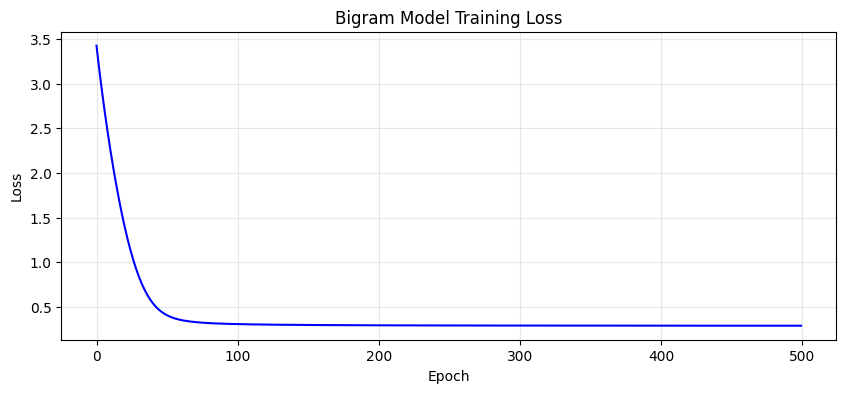

In [13]:
# Loss 曲线
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bigram Model Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

---

## 3. 可视化词向量空间

这是最激动人心的部分！让我们看看训练后的词向量在空间中是如何分布的。

In [14]:
# 获取训练后的词向量
word_vectors = model.embedding.weight.detach().numpy()

print("词向量形状:", word_vectors.shape)
print(f"每个词用 {word_vectors.shape[1]} 维向量表示")

# 用 PCA 降到2维进行可视化
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

print(f"\nPCA 解释方差比: {pca.explained_variance_ratio_}")

词向量形状: (28, 16)
每个词用 16 维向量表示

PCA 解释方差比: [0.149155   0.13365963]


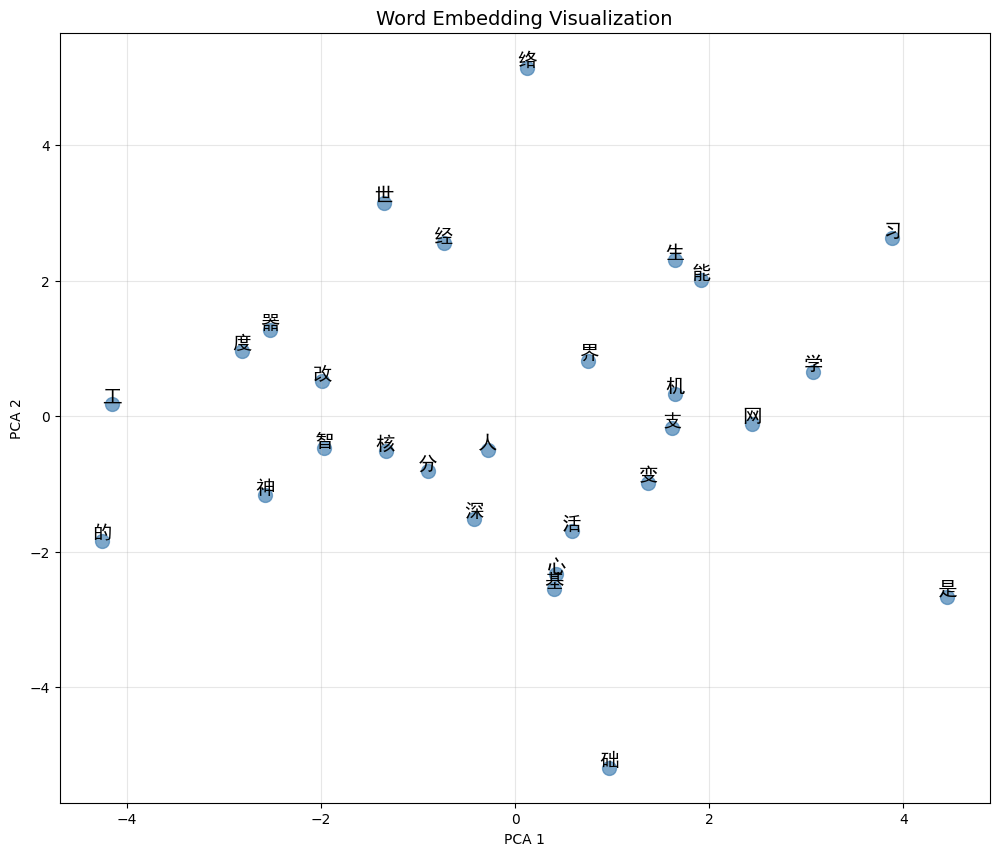

观察：语义相近的词在空间中距离更近！


In [15]:
# 可视化词向量
plt.figure(figsize=(12, 10))

# 画点
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], 
            c='steelblue', s=100, alpha=0.7)

# 标注每个词
for i, word in enumerate(vocab):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                 fontsize=14, ha='center', va='bottom',
                 fontproperties={'family': 'SimHei'})

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Word Embedding Visualization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print("观察：语义相近的词在空间中距离更近！")

---

## 4. 词向量的数学操作

词向量有一个神奇的性质：**语义关系可以用向量运算表示**

经典例子：
```
king - man + woman ≈ queen
```

In [16]:
# 计算词之间的相似度
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def find_similar(word, top_k=5):
    if word not in word2idx:
        print(f"词 '{word}' 不在词表中")
        return
    
    word_vec = word_vectors[word2idx[word]]
    similarities = []
    
    for w in vocab:
        if w != word:
            sim = cosine_similarity(word_vec, word_vectors[word2idx[w]])
            similarities.append((w, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"与 '{word}' 最相似的词:")
    for w, sim in similarities[:top_k]:
        print(f"  {w}: {sim:.4f}")

# 查找相似词
find_similar('学')
print()
find_similar('机')

与 '学' 最相似的词:
  习: 0.3968
  是: 0.3183
  活: 0.2908
  机: 0.2357
  基: 0.1985

与 '机' 最相似的词:
  心: 0.4365
  学: 0.2357
  是: 0.2301
  生: 0.2254
  界: 0.2150


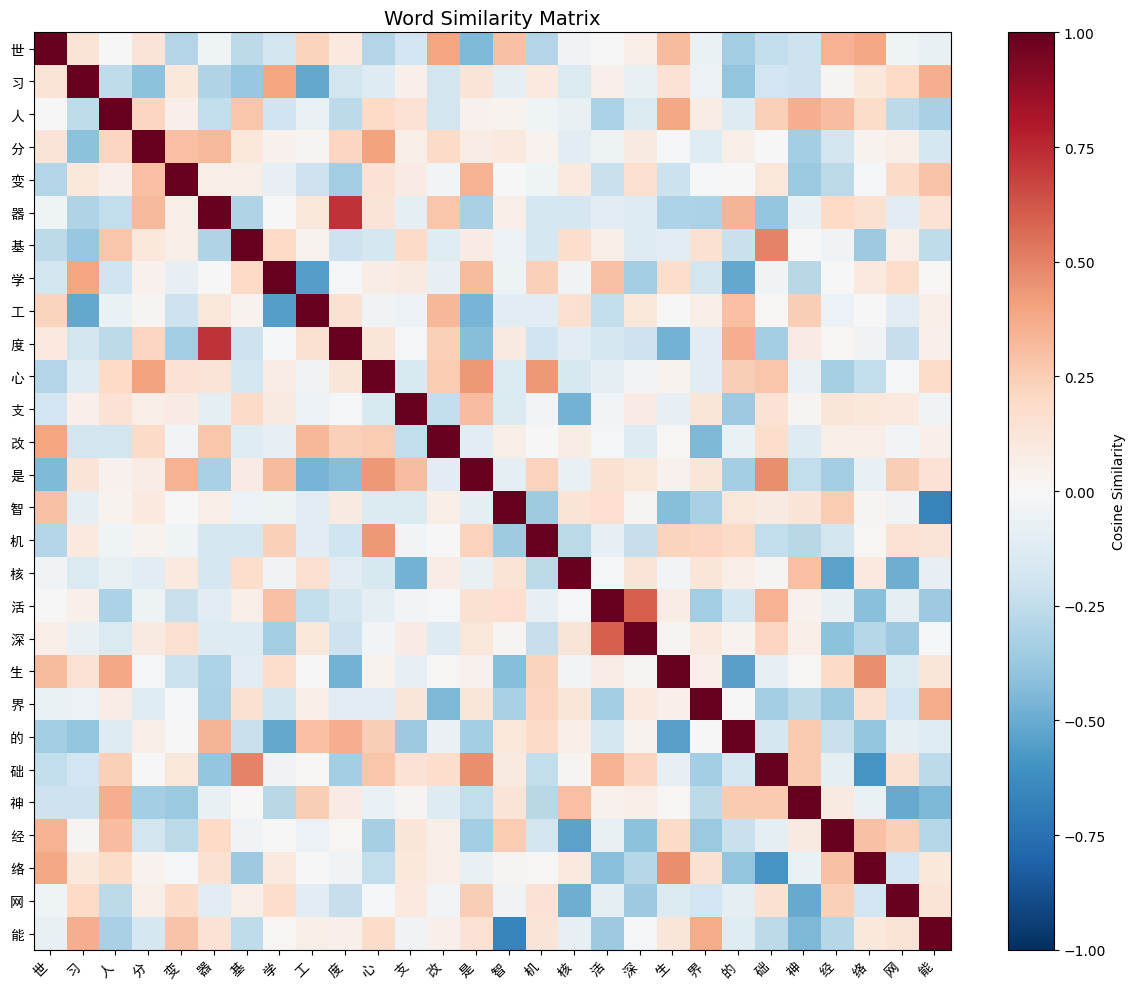

In [17]:
# 可视化词向量之间的相似度矩阵
similarity_matrix = np.zeros((vocab_size, vocab_size))

for i in range(vocab_size):
    for j in range(vocab_size):
        similarity_matrix[i, j] = cosine_similarity(
            word_vectors[i], word_vectors[j]
        )

plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(vocab_size), vocab, rotation=45, ha='right', fontproperties={'family': 'SimHei'})
plt.yticks(range(vocab_size), vocab, fontproperties={'family': 'SimHei'})
plt.title('Word Similarity Matrix', fontsize=14)
plt.tight_layout()
plt.show()

---

## 5. One-Hot vs Embedding

让我们对比一下两种词表示方式：

In [18]:
# One-Hot 编码
def one_hot(idx, vocab_size):
    vec = torch.zeros(vocab_size)
    vec[idx] = 1
    return vec

word_idx = 3
print(f"词 '{idx2word[word_idx]}' 的表示:")
print(f"\nOne-Hot ({vocab_size}维，稀疏):")
print(one_hot(word_idx, vocab_size))
print(f"\nEmbedding ({embed_dim}维，稠密):")
print(model.embedding.weight[word_idx].data)

print(f"\n对比:")
print(f"  One-Hot 维度:  {vocab_size}")
print(f"  Embedding 维度: {embed_dim}")
print(f"  维度压缩:      {vocab_size / embed_dim:.1f}x")

词 '分' 的表示:

One-Hot (28维，稀疏):
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Embedding (16维，稠密):
tensor([ 0.3415,  0.9383, -0.8667,  0.3241,  2.3779, -0.8218, -1.3840, -0.5099,
        -1.7204, -3.4285,  0.3375,  1.8515,  1.8891, -1.1982, -0.1877,  0.4351])

对比:
  One-Hot 维度:  28
  Embedding 维度: 16
  维度压缩:      1.8x


### One-Hot vs Embedding 对比

| 特性 | One-Hot | Embedding |
|:---|:---|:---|
| 维度 | 词表大小（可能很大） | 固定维度（通常256-1024） |
| 稀疏性 | 极度稀疏（只有1个1） | 稠密 |
| 语义关系 | 无法表达 | 相似词向量相近 |
| 可学习 | 否 | 是 |
| 内存占用 | O(词表大小) | O(嵌入维度) |

---

## 本章总结


1. **Embedding 的本质**
   - 就是一个查表矩阵 `[vocab_size, embed_dim]`
   - 输入词索引，输出对应向量
   - 通过训练学习语义关系

2. **词向量的魔力**
   - 把离散的词变成连续的向量
   - 语义相似的词，向量也相近
   - 支持向量运算表达语义关系

3. **核心洞察**
   - 机器不懂中文，但它懂向量空间里的几何位置
   - Embedding 是所有语言模型的基础


---

## 思考

1. **增加训练数据**：用更多文本训练，观察词向量质量的变化
2. **改变嵌入维度**：尝试不同的 `embed_dim`，观察对结果的影响
3. **实现词类比**：实现 `word1 - word2 + word3 ≈ word4` 的功能
4. **思考题**：为什么需要训练 Embedding，而不是用固定的向量？

In [ ]:
# 练习空间

